## BAGIAN 1: DATA PREPARATION & PROCESSING
Bagian ini fokus pada pembersihan dan penyiapan data sebelum analisis lebih lanjut.
1. Load Dataset:
    - df = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/komdigi/tbl_customer.csv'): Memuat data pelanggan dari file CSV yang disimpan di Google Cloud Storage ke dalam DataFrame pandas bernama df.
    - print("Data Loaded Successfully. Shape:", df.shape): Mencetak konfirmasi bahwa data telah berhasil dimuat, beserta dimensi (jumlah baris dan kolom) dari DataFrame.

2. Feature Selection for Clustering:
    - features = ['clicks', 'page_views', 'time_spent', 'add_to_cart']: Mendefinisikan daftar kolom yang akan digunakan sebagai fitur untuk proses clustering. Ini adalah metrik perilaku pelanggan.
    - X = df[features]: Membuat DataFrame baru X yang hanya berisi fitur-fitur yang dipilih dari DataFrame df.

3. Scaling Data (Standardization):
    - scaler = StandardScaler(): Menginisialisasi StandardScaler, sebuah alat dari scikit-learn yang digunakan untuk menstandarisasi fitur dengan menghilangkan rata-rata dan menskalakan ke varian unit. Ini penting karena algoritma K-Means sensitif terhadap skala data.
    - X_scaled = scaler.fit_transform(X): Menerapkan penskalaan pada data X. fit_transform menghitung parameter penskalaan (rata-rata dan standar deviasi) dari data, lalu menerapkannya untuk mengubah data.



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# ==========================================
# BAGIAN 1: DATA PREPARATION & PROCESSING
# ==========================================

# 1. Load Dataset
# Pastikan file 'tbl_customer.csv' ada di folder yang sama
df = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/komdigi/tbl_customer.csv')
print("Data Loaded Successfully. Shape:", df.shape)

# 2. Feature Selection untuk Clustering
# Kita hanya menggunakan fitur perilaku (behavioral)
features = ['clicks', 'page_views', 'time_spent', 'add_to_cart']
X = df[features]

# 3. Scaling Data (Sangat PENTING untuk K-Means)
# K-Means sensitif terhadap skala (detik vs jumlah klik), jadi kita standarisasi dulu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Data Loaded Successfully. Shape: (500000, 10)


## BAGIAN 2: BEHAVIORAL SEGMENTATION (CLUSTERING)
Bagian ini menggunakan algoritma K-Means untuk mengelompokkan pelanggan berdasarkan perilaku mereka.

1. Running K-Means Clustering:
    - kmeans = KMeans(n_clusters=4, random_state=42, n_init=10): Menginisialisasi model K-Means dengan 4 cluster. random_state=42 memastikan hasil yang dapat direproduksi, dan n_init=10 menjalankan algoritma K-Means 10 kali dengan centroid awal yang berbeda untuk menemukan solusi clustering terbaik.
    - df['cluster'] = kmeans.fit_predict(X_scaled): Menerapkan K-Means pada data yang telah diskalakan (X_scaled) dan menetapkan ID cluster (0, 1, 2, 3) untuk setiap pelanggan kembali ke DataFrame asli df.

2. Interpreting Clusters (Profiling):
    - cluster_summary = df.groupby('cluster')[features + ['conversion_label']].mean(): Menghitung rata-rata dari fitur perilaku dan tingkat konversi untuk setiap cluster. Ini membantu memahami karakteristik unik dari setiap segmen pelanggan
    - cluster_summary['count'] = df['cluster'].value_counts(): Menambahkan kolom ke cluster_summary yang menunjukkan jumlah pelanggan di setiap cluster.
    - cluster_summary['conversion_rate'] = cluster_summary['conversion_label'] * 100: Mengubah tingkat konversi dari desimal menjadi persentase.
    - label_cluster function: Sebuah fungsi placeholder (contoh) untuk memberikan label deskriptif kepada cluster berdasarkan karakteristik mereka. Ini biasanya dilakukan secara manual setelah menganalisis cluster_summary.
    - print("\n--- Profil Setiap Segmen ---") dan print(cluster_summary[...]): Mencetak ringkasan profil setiap segmen, menunjukkan metrik perilaku utama, tingkat konversi, dan jumlah anggota di setiap cluster.


In [6]:
# ==========================================
# BAGIAN 2: BEHAVIORAL SEGMENTATION (CLUSTERING)
# ==========================================

# 4. Menjalankan K-Means Clustering
# Kita pilih 4 cluster berdasarkan intuisi bisnis (e.g., Casual, Researcher, Buyer, Lost)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# 5. Interpretasi Cluster (Profiling)
# Melihat rata-rata perilaku di setiap cluster
cluster_summary = df.groupby('cluster')[features + ['conversion_label']].mean()
cluster_summary['count'] = df['cluster'].value_counts()
cluster_summary['conversion_rate'] = cluster_summary['conversion_label'] * 100 # dalam persen

# Memberikan label ke cluster (Contoh labeling otomatis)
def label_cluster(row):
    if row['add_to_cart'] > 0.8: return "High Intent Buyers"
    if row['time_spent'] > 300: return "Deep Researchers"
    if row['clicks'] < 3: return "Bouncers/Low Engagement"
    return "Casual Browsers"

# Terapkan labeling (Logic ini perlu disesuaikan setelah melihat hasil `cluster_summary`)
# Note: Logic di atas hanyalah contoh, sebaiknya print `cluster_summary` dulu untuk labeling yang akurat.

print("\n--- Profil Setiap Segmen ---")
print(cluster_summary[['clicks', 'time_spent', 'add_to_cart', 'conversion_rate', 'count']])


--- Profil Setiap Segmen ---
           clicks  time_spent  add_to_cart  conversion_rate   count
cluster                                                            
0        6.199286  102.439786     0.007314        15.046784  123867
1        2.737507   95.723171     0.000000        10.273847  201171
2        3.906607  438.022543     0.136403        20.381801   55893
3        4.020257  118.607883     1.000000        42.273808  119069


## BAGIAN 3: MARKETING CHANNEL EFFICIENCY & ATTRIBUTION
Bagian ini menganalisis kinerja saluran pemasaran dan bagaimana saluran-saluran tersebut membawa pelanggan dari berbagai segmen.
1. Channel Efficiency Analysis:
    - marketing_efficiency = df.groupby('referral_source').agg(...): Mengelompokkan data berdasarkan referral_source (saluran pemasaran) dan menghitung rata-rata tingkat konversi, rata-rata waktu yang dihabiskan (time_spent), dan volume traffic (jumlah pengguna) untuk setiap saluran.
    - marketing_efficiency['conversion_rate'] = marketing_efficiency['conversion_rate'] * 100: Mengubah tingkat konversi saluran menjadi persentase.
    - print("\n--- Efisiensi Channel Marketing ---") dan print(marketing_efficiency): Mencetak ringkasan efisiensi setiap saluran pemasaran.
2. Attribution: Which Segment is Brought by Which Channel?:
    - channel_cluster_dist = pd.crosstab(df['referral_source'], df['cluster'], normalize='index') * 100: Membuat tabel silang yang menunjukkan distribusi segmen pelanggan (cluster) untuk setiap saluran pemasaran, dinormalisasi berdasarkan baris untuk menunjukkan proporsi persentase.


In [7]:
# ==========================================
# BAGIAN 3: MARKETING CHANNEL EFFICIENCY & ATTRIBUTION
# ==========================================

# 6. Analisis Efisiensi Channel
marketing_efficiency = df.groupby('referral_source').agg({
    'conversion_label': 'mean', # Conversion Rate
    'time_spent': 'mean',       # Engagement Quality
    'user_id': 'count'          # Traffic Volume
}).rename(columns={'conversion_label': 'conversion_rate', 'user_id': 'traffic_volume'})

marketing_efficiency['conversion_rate'] = marketing_efficiency['conversion_rate'] * 100

# 7. Attribution: Segmen mana yang dibawa oleh Channel mana?
channel_cluster_dist = pd.crosstab(df['referral_source'], df['cluster'], normalize='index') * 100

print("\n--- Efisiensi Channel Marketing ---")
print(marketing_efficiency)


--- Efisiensi Channel Marketing ---
                 conversion_rate  time_spent  traffic_volume
referral_source                                             
Ads                    19.928147  141.046203           49824
Direct                 20.265880  141.521145          100045
Email                  19.994965  140.991082           75469
Google                 20.294685  140.798743          149719
Instagram              20.292453  141.215426          124943


### Analisis Tabel Efisiensi Channel Marketing

Tabel ini menceritakan 3 hal utama:
1. Fenomena "Kualitas Identik" (Conversion Rate)
Lihat kolom conversion_rate.
  - Google & Instagram: 20.29% (Tertinggi)
  - Ads: 19.92% (Terendah)
  - Selisih: Hanya 0.37%.
  - Artinya: Secara statistik, tidak ada bedanya user datang dari mana. Mau mereka klik iklan berbayar (Ads) atau datang gratis dari Google Search, peluang mereka membeli barang hampir sama persis, yaitu sekitar 1 dari 5 orang (20%).
  - Insight: Biasanya, traffic berbayar (Ads) diharapkan punya konversi lebih tinggi karena kita menargetkan audiens khusus. Tapi di sini, Ads justru kalah tipis dari traffic organik.
2. Pola Perilaku yang "Kembar" (Time Spent)
Lihat kolom time_spent.
  - Semua channel berada di angka 140 - 141 detik.
  - User dari Direct (ketik URL sendiri) menghabiskan 141.5 detik.
  - User dari Google menghabiskan 140.8 detik.
  - Artinya: Sumber traffic tidak mempengaruhi seberapa betah user di website. Tidak ada channel yang mendatangkan user yang "terburu-buru" atau user yang "lebih santai". Semua berperilaku sama begitu masuk website.
3. Google adalah Raja Traffic (Traffic Volume)
Lihat kolom traffic_volume.
  - Google: ~150.000 user (30% dari total).
  - Ads: ~50.000 user (Hanya 10% dari total).
  - Artinya: Mesin utama bisnis Anda adalah Google (Organic Search). Ia mendatangkan traffic 3x lipat lebih banyak daripada Iklan Berbayar (Ads), dengan kualitas konversi yang justru sedikit lebih baik.
________________________________________

### Kesimpulan Bisnis & Rekomendasi (Actionable Insights)
Berdasarkan tabel ini, sebagai Data Scientist saya merekomendasikan:
1. Evaluasi Ulang Budget Iklan (Ads): Anda membayar uang untuk setiap klik di channel "Ads". Namun, tabel menunjukkan performa Ads (19.9% konversi) lebih rendah daripada channel gratisan seperti Google/Direct/Instagram (20.29%).
    - Saran: Jika biaya iklan mahal, kurangi budget Ads. Anda tidak mendapatkan user yang lebih "premium" dari sana. Uang Anda mungkin "terbakar" tanpa memberikan keunggulan dibanding traffic gratis.

2. Pertahankan SEO (Google): Google adalah tulang punggung bisnis ini (Volume terbesar + Konversi tertinggi). Pastikan posisi ranking website di Google tidak turun, karena ini sumber pendapatan utama.

3. Misteri Instagram: Instagram menyumbang traffic besar (125k) dengan konversi tinggi (20.29%). Ini indikasi brand Anda kuat di media sosial secara organik. Terus genjot konten di sana karena biayanya (biasanya) lebih murah dari Ads berbayar.
Singkatnya: Data ini berteriak bahwa Traffic Organik (Google & Instagram) adalah juara, sedangkan Traffic Berbayar (Ads) performanya biasa saja (underperforming) jika dilihat dari sisi konversi.


## BAGIAN 4: VISUALISASI DASHBOARD (CHART)
Bagian ini membuat beberapa plot untuk memvisualisasikan hasil analisis.
1. Setup Figure Size:
    - plt.figure(figsize=(20, 12)): Mengatur ukuran keseluruhan dari kumpulan plot agar lebih mudah dibaca.
2. Visualisasi 1: Karakteristik Cluster (Heatmap):
    - plt.subplot(2, 2, 1): Membuat subplot pertama dalam tata letak grid 2x2.
    - sns.heatmap(cluster_summary[features].T, cmap='YlGnBu', annot=True, fmt='.2f'): Menampilkan heatmap dari ringkasan perilaku per cluster. Ini membantu membandingkan rata-rata fitur (klik, page views, waktu dihabiskan, add to cart) di antara cluster, dengan anotasi nilai numerik.
    - plt.title('Fingerprint Prilaku per Cluster (Rata-rata)', fontsize=14): Menambahkan judul ke plot.
3. Visualisasi 2: Marketing Efficiency (Bar Chart with Labels):
    - plt.subplot(2, 2, 2): Membuat subplot kedua.
    - ax2 = sns.barplot(x=marketing_efficiency.index, y='conversion_rate', data=marketing_efficiency, palette='viridis'): Membuat bar chart yang menunjukkan tingkat konversi per saluran pemasaran.
    - Menambahkan Label Angka: Kode iterasi for container in ax2.containers: dan ax2.bar_label(...) menambahkan label persentase di atas setiap bar untuk memudahkan pembacaan.
    - Menambahkan judul, label sumbu y, dan mengatur batas sumbu y.
4. Visualisasi 3: Channel x Cluster Stacked Bar (with Inner Labels):
    - plt.subplot(2, 2, 3): Membuat subplot ketiga.
    - ax3 = channel_cluster_dist.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Set2'): Membuat bar chart bertumpuk yang menunjukkan komposisi segmen pelanggan (cluster) untuk setiap saluran pemasaran. Setiap bar mewakili saluran, dan segmen di dalamnya menunjukkan proporsi pelanggan dari cluster yang berbeda yang berasal dari saluran tersebut.
    - Menambahkan Label Angka di Dalam Bar: Kode iterasi for c in ax3.containers: dan ax3.bar_label(...) menambahkan label persentase di tengah setiap bagian tumpukan bar.
    - Menambahkan judul, label sumbu y, dan legenda.
5. Visualisasi 4: Peta Persebaran User (PCA):
    - plt.subplot(2, 2, 4): Membuat subplot keempat.
    - pca = PCA(n_components=2): Menginisialisasi Principal Component Analysis (PCA) untuk mengurangi dimensi data perilaku ke 2 komponen utama. Ini digunakan untuk visualisasi karena sulit memvisualisasikan data 4 dimensi secara langsung.
    - coords = pca.fit_transform(X_scaled): Menerapkan PCA pada data yang diskalakan untuk mendapatkan koordinat 2D.
    - scatter = plt.scatter(coords[:, 0], coords[:, 1], c=df['cluster'], cmap='viridis', alpha=0.5, s=10): Membuat scatter plot dari koordinat PCA, di mana setiap titik adalah pelanggan dan diwarnai berdasarkan cluster tempat mereka berada. Ini membantu memvisualisasikan bagaimana cluster-cluster tersebut terpisah di ruang fitur.
    - Menambahkan judul, label sumbu, dan legenda untuk cluster.
6. Layout and Display:
    - plt.tight_layout(): Menyesuaikan parameter subplot secara otomatis agar pas dengan area gambar, mencegah tumpang tindih.
    - plt.show(): Menampilkan semua plot yang telah dibuat.


/tmp/ipython-input-356960109.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=marketing_efficiency.index, y='conversion_rate', data=marketing_efficiency, palette='viridis')


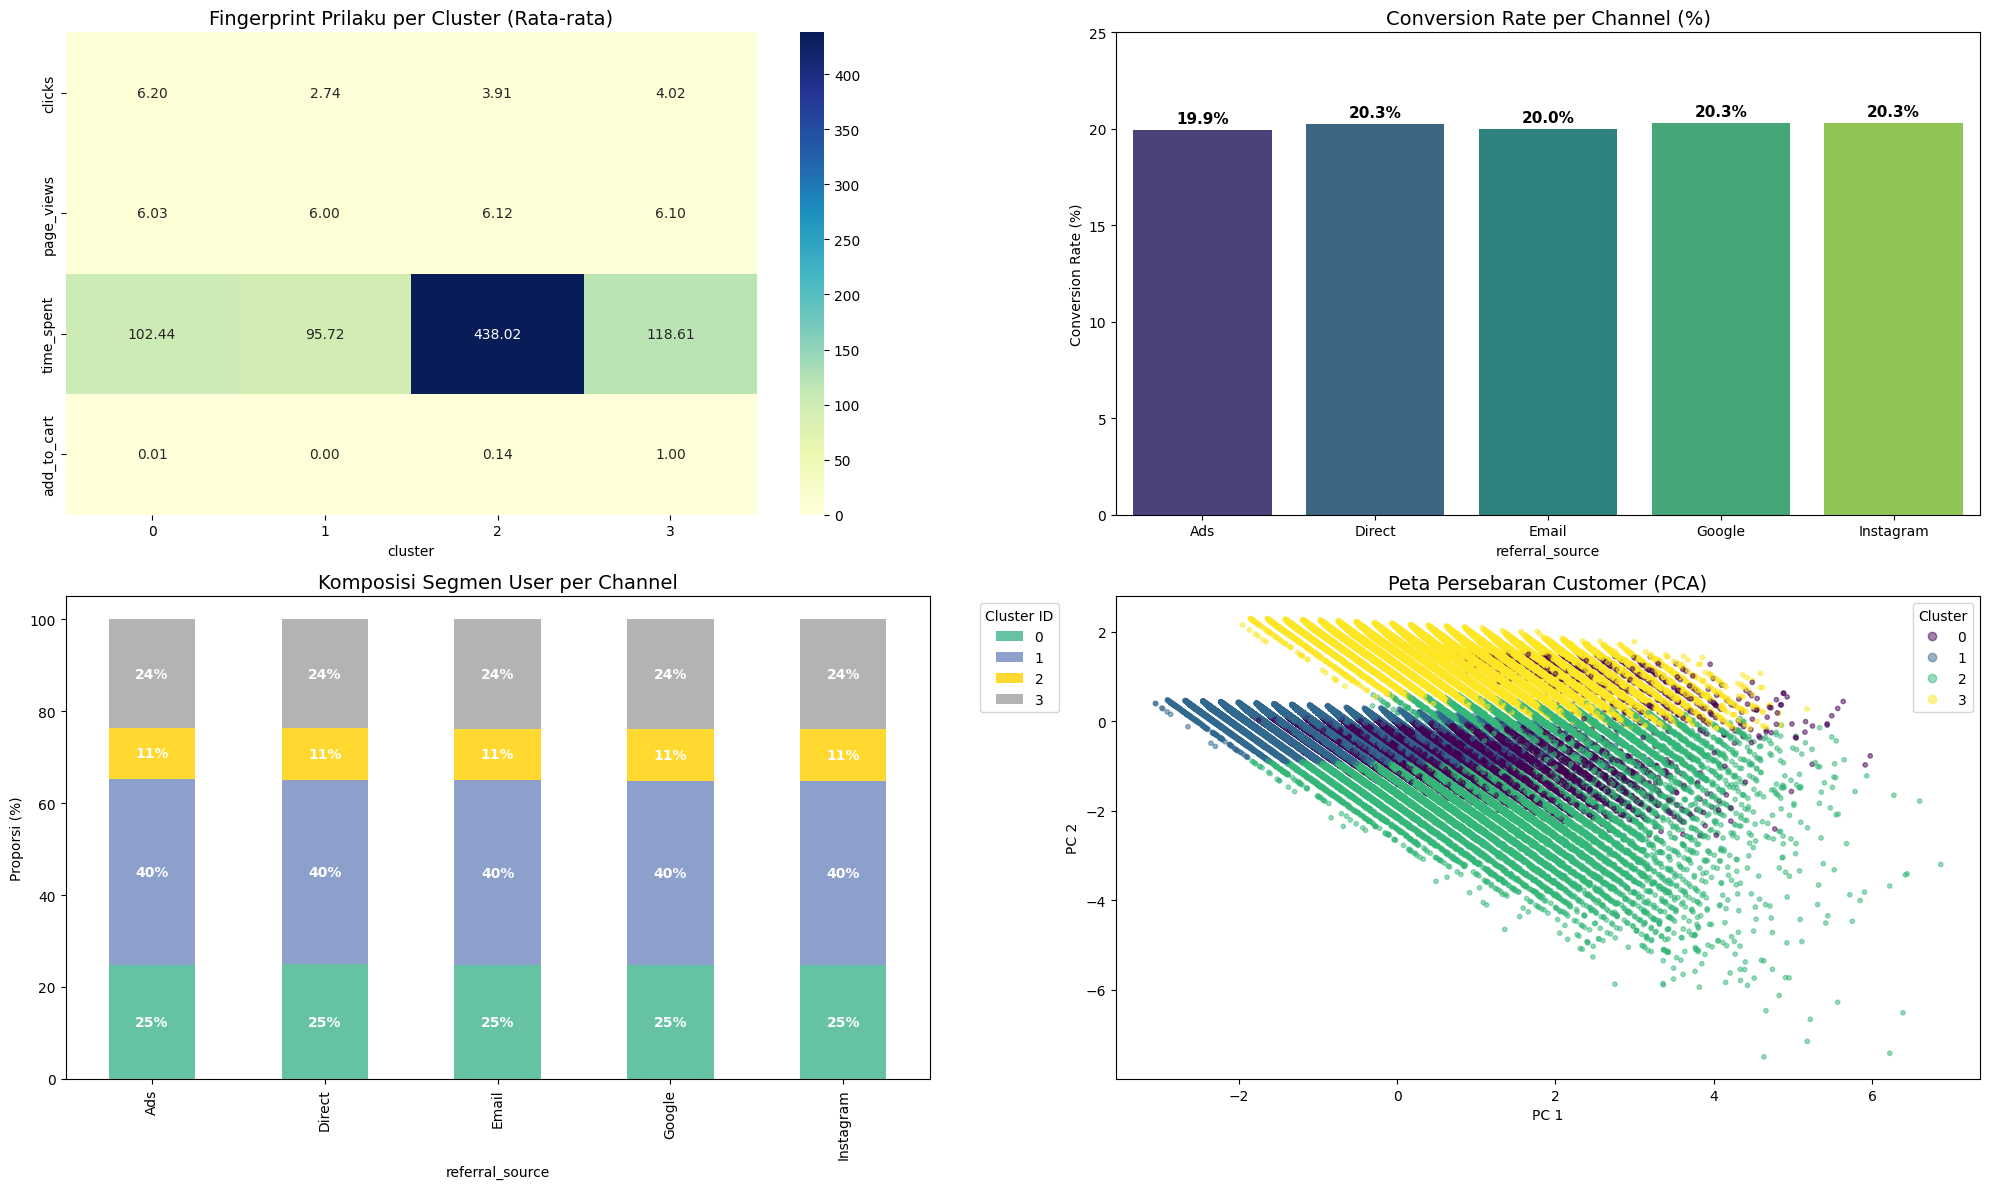

In [8]:
# ==========================================
# BAGIAN 4: VISUALISASI DASHBOARD (CHART)
# ==========================================

plt.figure(figsize=(20, 12)) # Ukuran sedikit diperbesar agar angka muat

# --- Visualisasi 1: Karakteristik Cluster (Heatmap) ---
plt.subplot(2, 2, 1)
sns.heatmap(cluster_summary[features].T, cmap='YlGnBu', annot=True, fmt='.2f')
plt.title('Fingerprint Prilaku per Cluster (Rata-rata)', fontsize=14)

# --- Visualisasi 2: Marketing Efficiency (Bar Chart dengan Label) ---
plt.subplot(2, 2, 2)
ax2 = sns.barplot(x=marketing_efficiency.index, y='conversion_rate', data=marketing_efficiency, palette='viridis')

# [NEW] Menambahkan label angka di atas bar
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.1f%%', padding=3, fontsize=11, fontweight='bold')

plt.title('Conversion Rate per Channel (%)', fontsize=14)
plt.ylabel('Conversion Rate (%)')
plt.ylim(0, 25) # Memberi ruang di atas bar untuk label angka

# --- Visualisasi 3: Channel x Cluster Stacked Bar (dengan Label di Dalam) ---
plt.subplot(2, 2, 3)
ax3 = channel_cluster_dist.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Set2')

# Menambahkan label angka di tengah-tengah stack (center)
for c in ax3.containers:
    # label_type='center' menaruh angka di tengah bar
    # color='white' agar kontras dengan warna bar
    # fmt='%.0f%%' membulatkan angka desimal agar rapi
    ax3.bar_label(c, fmt='%.0f%%', label_type='center', color='white', fontweight='bold', fontsize=10)

plt.title('Komposisi Segmen User per Channel', fontsize=14)
plt.ylabel('Proporsi (%)')
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# --- Visualisasi 4: Peta Persebaran User (PCA) ---
plt.subplot(2, 2, 4)
pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=df['cluster'], cmap='viridis', alpha=0.5, s=10)
plt.title('Peta Persebaran Customer (PCA)', fontsize=14)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
# Menambahkan legend untuk PCA agar warna cluster jelas
plt.legend(*scatter.legend_elements(), title="Cluster", loc="upper right")

plt.tight_layout()
plt.show()

### 1. Heatmap (Fingerprint Prilaku per Cluster)
- Apa yang harus dilihat: Warna Gelap vs Terang & Angka di dalam kotak.
  - Fungsi: Ini adalah "DNA" atau identitas dari setiap kelompok user.
  - Cara Baca:Lihat baris time_spent (Waktu yang dihabiskan). Anda akan melihat satu kotak yang warnanya sangat berbeda (misalnya sangat gelap atau sangat terang) di Cluster 2. Angka rata-ratanya 438. Ini visualisasi yang menegaskan bahwa Cluster 2 adalah kelompok "Orang yang betah berlama-lama".
  - Lihat baris add_to_cart. Ada satu cluster (Cluster 3) yang angkanya 1.00 (maksimal). Ini mendefinisikan Cluster 3 sebagai "The Buyers".
  - Insight Bisnis: Chart ini membuktikan bahwa user Anda tidak homogen. Ada perbedaan perilaku yang ekstrem antar kelompok, sehingga kita tidak bisa memperlakukan semua user dengan cara yang sama (misalnya, memberikan diskon cepat ke "The Researcher" mungkin salah strategi karena mereka butuh informasi, bukan sekadar harga murah).

### 2. Bar Chart (Conversion Rate per Channel)
- Apa yang harus dilihat: Ketinggian Batang & Label Angka di atasnya.
  - Fungsi: Rapor kinerja channel marketing Anda.
  - Cara Baca:
  - Perhatikan bahwa tinggi kelima batang tersebut hampir rata (Flat).
  - Angka labelnya menunjukkan 19.9% (Ads) hingga 20.3% (Google). Perbedaannya sangat tipis, nyaris tak kasat mata.
  - Insight Bisnis: Visualisasi "datar" ini adalah bukti kuat untuk manajer keuangan/marketing. Ini menunjukkan bahwa strategi "membayar lebih mahal" di Ads tidak menghasilkan konversi yang lebih tinggi. Secara visual, ini menampar asumsi bahwa "Ads = Penjualan Tinggi". Realitanya, Ads performanya sama saja dengan traffic gratisan.

### 3. Stacked Bar (Komposisi Segmen User per Channel)
- Apa yang harus dilihat: Pola Garis/Warna pada setiap batang.
  - Fungsi: Melihat "Isi Jeroan" dari setiap channel. Apakah Instagram membawa user berkualitas?
  - Cara Baca: Setiap batang mewakili channel (Ads, Email, dll).Warna-warni di dalam batang mewakili proporsi cluster (misal: Hijau = Buyer, Biru = Window Shopper).
  - Pola Penting: Perhatikan bahwa komposisi warnanya identik di semua channel. Garis hijaunya sama tebal, garis birunya sama tebal.
  - Insight Bisnis: Ini mengindikasikan Broad Targeting (Targeting yang terlalu umum).

  Jika Instagram memiliki algoritma targeting yang hebat, seharusnya bagian warna "Buyer" (Cluster 3) di batang Instagram jauh lebih besar daripada di batang Google.

  Kenyataannya, proporsinya sama. Ini berarti iklan Anda di Instagram menjaring "siapa saja", bukan spesifik menjaring "pembeli".

### 4. Chart Kanan Bawah: Scatter Plot (Peta Persebaran/PCA)
- Apa yang harus dilihat: Gerombolan Titik Warna.
  - Fungsi: Membuktikan secara matematis bahwa pengelompokan (segmentasi) ini valid.
  - Cara Baca: Grafik ini memetakan 500.000 user ke dalam peta 2 dimensi.
  - Anda akan melihat titik-titik dengan warna yang sama berkumpul membentuk "pulau" sendiri.
  - Mungkin ada satu kelompok warna (misalnya Cluster 2 - The Researcher) yang terpisah agak jauh dari kelompok lain.
  - Insight Bisnis: Jarak antar kelompok menunjukkan seberapa beda perilaku mereka.

  Jika kelompok "Researcher" terpisah jauh dari "Buyer", itu artinya cara pendekatan marketingnya harus beda total. Anda tidak bisa menggunakan materi iklan (copywriting) yang sama untuk dua kelompok yang berada di "pulau" yang berjauhan ini.